In [7]:
#loading libraries
import re
import pandas as pd
import numpy as np
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay
import joblib


In [8]:
# Path to the CSV file
DATA_PATH = "Dataset/phishing_site_urls_2.csv"

# Load the phishing URL dataset
df = pd.read_csv(DATA_PATH)
display(df.head())


,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,1
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,1
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,1
3,mail.printakid.com/www.online.americanexpress....,1
4,thewhiskeydregs.com/wp-content/themes/widescre...,1


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549358 entries, 0 to 549357
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     549358 non-null  object
 1   Label   549358 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 8.4+ MB


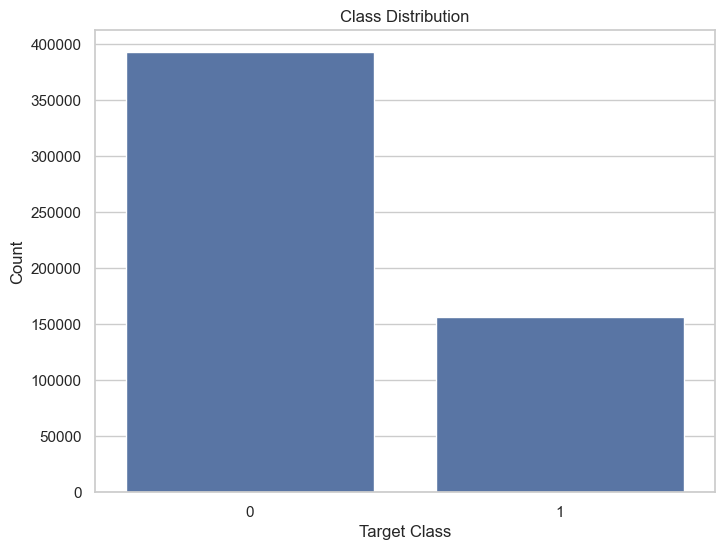

In [10]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
plt.title("Class Distribution")
sns.set_palette("Set2")
sns.countplot(x='Label', data=df)
plt.xlabel("Target Class")
plt.ylabel("Count")
plt.show()


In [11]:
def extract_features(url):
    url = url.lower()  # lowercase for consistency

    # Extract domain part
    domain = url.split('/')[0]

    return {
        'url_length': len(url),
        'num_digits': sum(c.isdigit() for c in url),
        'num_special_char': len(re.findall(r'\W', url)),
        'has_https': int('https' in url),
        'num_dots': url.count('.'),
        'has_ip': int(bool(re.search(r'\d+\.\d+\.\d+\.\d+', url))),
        'has_suspicious_words': int(any(word in url for word in [
            'login', 'verify', 'update', 'secure', 'account', 'bank', 'webscr', 'signin'
        ])),

        'is_exe_file': int(url.endswith('.exe')),  # common malicious pattern
        'domain_length': len(domain),
        'tld_is_suspicious': int(url.endswith(('.xyz', '.ru', '.tk', '.top', '.info')))  # risky TLDs
    }

In [12]:
# Generate features and labels first
features = df['URL'].apply(extract_features)
X = pd.DataFrame(features.tolist())
y = df['Label']


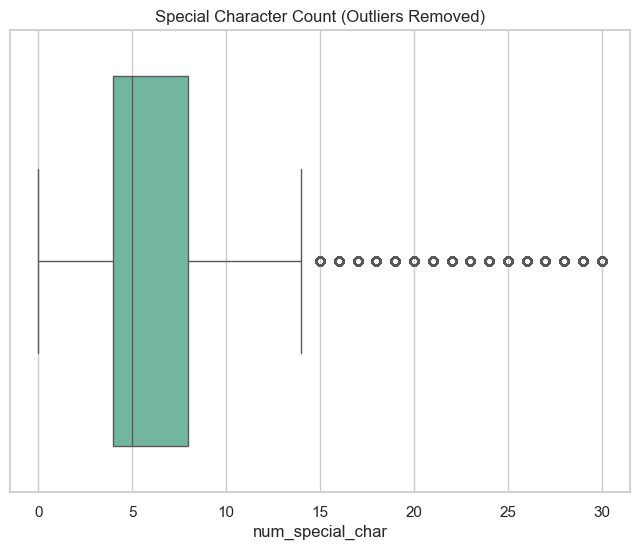

In [13]:
# Data cleaning
# Removing records with very short URLs (e.g., length < 5)
X_cleaned = X.drop(X[X['url_length'] < 5].index, axis=0)
y_cleaned = y.loc[X_cleaned.index]

# Winsorizing extremely high special character count
special_char_upper_fence = 30
X_cleaned['num_special_char'] = X_cleaned['num_special_char'].clip(upper=special_char_upper_fence)

# Visualizing the distribution of special characters after clipping
plt.figure(figsize=(8, 6))
sns.boxplot(x=X_cleaned['num_special_char'])
plt.title("Special Character Count (Outliers Removed)")
plt.show()


In [15]:
# check for missing data
print(X_cleaned.isnull().sum())
print(y_cleaned.isnull().sum())


url_length              0
num_digits              0
num_special_char        0
has_https               0
num_dots                0
has_ip                  0
has_suspicious_words    0
is_exe_file             0
domain_length           0
tld_is_suspicious       0
dtype: int64
0


In [16]:
# Separating the target feature from the input features
predictor_vars = X_cleaned
target_var = y_cleaned


In [17]:

# Standardizing the features using Z-score
standardized_predictors = predictor_vars.apply(zscore)
# Display the first few records
print(standardized_predictors.head())


   url_length  num_digits  num_special_char  has_https  num_dots    has_ip  \
0    3.923945    4.598667          4.666220  -0.042101  2.599796 -0.123811   
1    0.681675   -0.326074          1.635606  -0.042101  1.939559 -0.123811   
2    2.843188    3.648279          2.717968  -0.042101  3.260034 -0.123811   
3    0.208844   -0.412473          0.336771  -0.042101  2.599796 -0.123811   
4    1.469726    1.401906          1.419133  -0.042101 -0.701391 -0.123811   

   has_suspicious_words  is_exe_file  domain_length  tld_is_suspicious  
0              3.773857     -0.07446      -0.703280          -0.021337  
1              3.773857     -0.07446      -0.186464          -0.021337  
2              3.773857     -0.07446      -0.100327          -0.021337  
3             -0.264981     -0.07446       0.071945          -0.021337  
4             -0.264981     -0.07446       0.158081          -0.021337  


In [18]:
# Splitting the data into train and test sets (70% train, 30% test)
train_predictors, test_predictors, train_targets, test_targets = train_test_split(
    standardized_predictors, target_var,
    test_size=0.30,
    random_state=42
)

In [19]:

# Model training
# Initialize the instance of the algorithm
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=25,
    class_weight='balanced_subsample',
    random_state=42,
)
# Using the instance to train the algorithm
rf_model.fit(train_predictors, train_targets)


RandomForestClassifier(class_weight='balanced_subsample', max_depth=25,
                       n_estimators=300, random_state=42)

In [20]:

# Making predictions on the test set
test_predictions = rf_model.predict(test_predictors)

# Printing full classification report
print("Classification Report:")
print(classification_report(test_targets, test_predictions))


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.91    117920
           1       0.76      0.78      0.77     46886

    accuracy                           0.87    164806
   macro avg       0.83      0.84      0.84    164806
weighted avg       0.87      0.87      0.87    164806



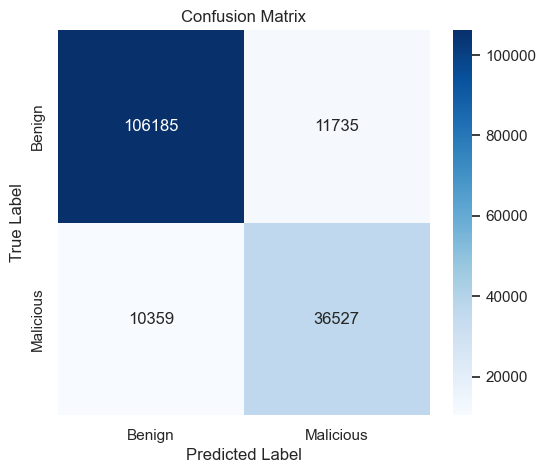

In [21]:

# Visualizing the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(test_targets, test_predictions),annot=True, fmt='d', cmap='Blues',xticklabels=['Benign', 'Malicious'],yticklabels=['Benign', 'Malicious'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


<Figure size 800x600 with 0 Axes>

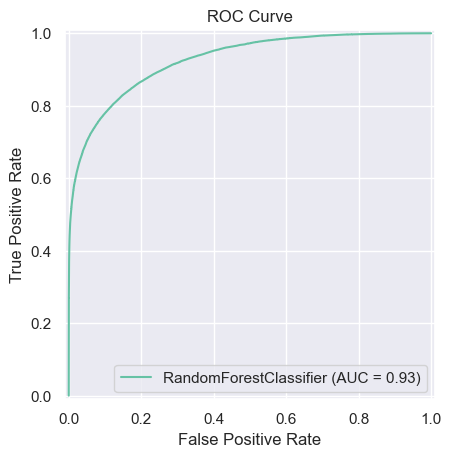

In [22]:
# ROC Curve
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_estimator(rf_model, test_predictors, test_targets)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.show()


In [23]:
joblib.dump(rf_model, 'url_detector_model.pkl')
print(" Model saved as url_detector_model.pkl")


 Model saved as url_detector_model.pkl
